## Instructions:
- You can use NN libraries such as tensorflow, pytorch, etc. But implement NF and importance sampling on your own.
- Zero tolerance for plagiarism. Do not copy from Practice and Share; the student who submitted there originally only can use; Github tracks who pushed what code.
- Total marks: 50 + 5 (bonus)
- Marks will be for plots and explanations. Describe your experiments, observations, challenges-faced, hyper-parameter tuning, etc., in the explanations.

In [242]:
import CodingQuiz1lib as given
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt

# NOTE:
Tensorflow makes use of auto-differentiation to allow for easy back-proagation. For that, it is important all the relevant parameters are Tensors and all the operations should be tf operations.  

In this experiment, we make use of tensorflow_probability to create the same distributions.  

For the ```Gaussian``` we simply make use of ```tfp.distributions.MultivariateNormalDiag``` with the exact same parameters used for ```given.Gaussian```.  

Similarly for the ```GMM``` we have used :    
```tfd.MixtureSameFamily(  mixture_distribution=tfd.Categorical(probs=pi),  components_distribution=tfd.MultivariateNormalTriL(loc=mu,scale_tril=scale))```

We first run ```given.GMM()``` and use its parameters for the GMM constructed using Tensorflow.  

### Why is this needed? 
In the KL divergence loss, we have a term $log(p_u(T^{-1}(x; \phi))$. This consists of the trainable parameter $\phi$ and hence we need $p_u$ to have operations in terms of tf operations in order to be able to use auto-differentation. However, in the library given, we have these functions in terms of numpy operations.  

Similarly in the reverse KL divergence loss, we have $log(p_x^*(T(u; \phi)))$ and so we need a form of $p_x^*$ in terms of tf operations.  

The issue is not only in terms of converting numpy to tf or vice-versa. We can make the Coding Library compatible by data type-casting but as soon as we convert a tf tensor to numpy, we lose all the gradient information. And tf decorator functions won't help us here because the data type being passed into the Coding library is a numpy array and numpy arrays don't have the functionality to store gradient information.  

Also, even if we use the library as it is, there will be some kind of training since the determinant term still has some gradient information, but this gradient information  by itself is not the full information.  


In my humble opinion, using the tensorflow probability distributions doesn't take away the main learning purpose of this assignment since we need to implement Normalizing Flows and run experiements to understand those models better.  
 It is my very sincere request to you to please consider this submission which has proper experiments to run Normalizing Flow and understand the models.


In [243]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow_probability as tfp
tfd = tfp.distributions 

# Q1: Model a 2D GMM using NF
- Prepare the target probability distribution $p_x^*$ as a GMM with 5 components
```
    ptarget = given.GMM()  
    samples = ptarget.sample(5) # to obtain 5 samples
    given.plot_samples_2d(samples, filename='target')   # plot the samples in file
    ptarget.prob(samples)       # to obtain probability values of samples
```
- Prepare the source distribution $p_u$ as a Gaussian with zero mean and unit variance. Use `given.Gaussian`.

## a.
- Given only the samples from the target distribution, train an NF $x=T(u)$ to model that distribution. Use any flow of your choice.
- Evaluation:
    - Generate samples from the model and plot them using `given.plot_samples_2d()`. Also plot samples from target distribution for comparison. Write your obervations in the markdown block below the plots. [10 marks]
    - Generate samples from the given target distribution and estimate their probabilities using the model as well as `ptarget.prob()`. Plot a histogram of the absolute difference in the two probability values. Write your obervations in the markdown block below the plots. [10 marks]

## b.
- Given only the function `ptarget.prob()` from the target distribution, train an NF to model that distribution.
- Evaluation:
    - Generate samples from the model and plot them using `given.plot_samples_2d()`. Also plot samples from target distribution for comparison. Write your obervations in the markdown block below the plots. [10 marks]
    - Generate samples from the given target distribution and estimate their probabilities using the model as well as `ptarget.prob()`. Plot a histogram of the absolute difference in the two probability values. Write your obervations in the markdown block below the plots. [10 marks]

## c. (BONUS)
- Draw plots that may help understand your models better. Write your obervations in the markdown block below the plots. [5 marks]

## YOUR CODE:

I have made use of the RNVP flows provided by Prof. Arora in the github examples. In addition, I have implemented Planar Flows myself.  

I decided to make use of this quiz an exercise to see some differences in the performance of RNVP Flows and Planar Flows

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1465 11818 40808 44541  1368]


array([0.04007126, 0.01870453, 0.01300226, ..., 0.03913935, 0.01340359,
       0.01348515])

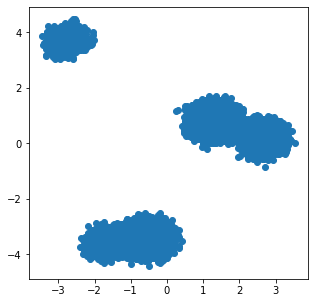

In [244]:
# CREATING THE TARGET DISTRIBUTION ACCORDING TO LIBRARY
ptarget = given.GMM()
samples = ptarget.sample(100000) # to obtain samples
given.plot_samples_2d(samples, filename='target') # plot the samples in file
ptarget.prob(samples)       # to obtain probability values of samples

In [245]:
# Creating the same GMM using tensorflow distributions
pi = ptarget.weights
mu = []
cov = []
for i in range(len(pi)):
    mu.append(ptarget.components[i].mu)
    cov.append(ptarget.components[i].sigma)
scale = tf.linalg.cholesky(cov)

In [246]:
mvgmm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=pi),
    components_distribution=tfd.MultivariateNormalTriL(loc=mu,scale_tril=scale))

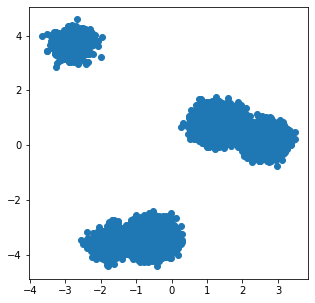

In [247]:
given.plot_samples_2d(mvgmm.sample(100000))

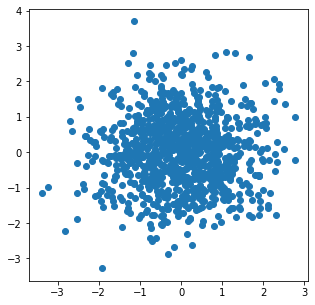

In [248]:
# Creating the base distribution
p_u = given.Gaussian(mu=[0,0], sigma=np.eye(2))
given.plot_samples_2d(p_u.sample(1000))

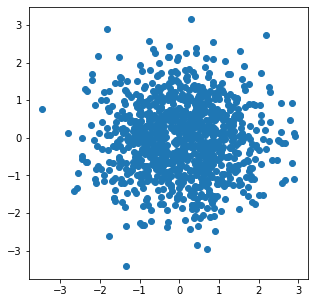

In [249]:
base_dist = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros([2]), scale_diag=[1.0, 1.0])
given.plot_samples_2d(base_dist.sample(1000))

In [250]:
##### Q1 a. #####

# Q1. a

## RNVP Flow 

In [251]:
class NN(layers.Layer):
    """
    Neural Network Architecture for calcualting s and t for Real-NVP
    
    :param input_shape: shape of the data coming in the layer
    :param hidden_units: Python list-like of non-negative integers, specifying the number of units in each hidden layer.
    :param activation: Activation of the hidden units
    """
    def __init__(self, input_shape, n_hidden=[64,64], activation="relu"):
        super(NN, self).__init__(name="nn")
        layer_list = []
        for n in n_hidden:
            layer_list.append(layers.Dense(n, activation=activation))
        self.layer_list = layer_list
        self.log_s_layer = layers.Dense(input_shape, activation="tanh", name='log_s')
        self.t_layer = layers.Dense(input_shape, name='t')

    def call(self, x):
        y = x
        for layer in self.layer_list:
            y = layer(y)
        log_s = self.log_s_layer(y)
        t = self.t_layer(y)
        return log_s, t
    

class RealNVP:
    """
    Implementation of a Real-NVP for Density Estimation. L. Dinh “Density estimation using Real NVP,” 2016.
    This implementation only works for 1D arrays.
    :param input_shape: shape of the data coming in the layer
    :param hidden_units: Python list-like of non-negative integers, specifying the number of units in each hidden layer.
    """

    def __init__(self, input_shape, flip):
        assert input_shape % 2 == 0
        input_shape = input_shape // 2
        nn = NN(input_shape)
        x = keras.Input(input_shape)
        log_s, t = nn(x)
        self.nn = keras.Model(x, [log_s, t], name="nn")
        self.flip = flip
        #print(self.nn.summary())
        
    def _forward(self, u):
        u1, u2 = tf.split(u, 2, axis=-1)

        if self.flip == True:
          u1, u2 = u2, u1

        x1 = u1
        log_s, mu = self.nn(u1)
        x2 = u2 * tf.exp(log_s) + mu 

        if self.flip == True:
          x1, x2 = x2, x1
        
        x = tf.concat([x1, x2], axis=-1)
        return x, log_s

    def _inverse(self, x):
        x1, x2 = tf.split(x, 2, axis=-1)

        if self.flip == True:
          x1, x2 = x2, x1
        
        u1 = x1
        log_s, mu = self.nn(x1)
        u2 = (x2 - mu)/tf.exp(log_s)

        if self.flip == True:
          u1, u2 = u2, u1
        
        u = tf.concat([u1, u2], axis=-1)
        return u, log_s


class NormalizingFlowRNVP:

    def __init__(self, D, n_flows):
        flip = False
        self.n_flows = n_flows
        self.rnvp_chain = []
        for i in range(n_flows):
            self.rnvp_chain.append(RealNVP(2, flip))
            flip = not flip
    
    def complete_inverse(self, x):
        u = x
        log_det_jacob_inv_transf = 0
        for i in range(self.n_flows-1,-1,-1):
            u, log_s = self.rnvp_chain[i]._inverse(u)
            log_det_jacob_inv_transf = log_det_jacob_inv_transf - log_s
        return u, log_det_jacob_inv_transf

    def complete_forward(self, u):
        x = u
        log_det_jacob_forward_transf = 0
        for i in range(self.n_flows):
            x, log_s = self.rnvp_chain[i]._forward(x)
            log_det_jacob_forward_transf = log_det_jacob_forward_transf + log_s
        return x, log_det_jacob_forward_transf

Given samples from $p_x^*(x)$, estimate the density using RNVP flows.

In [252]:
nf_rnvp = NormalizingFlowRNVP(2, 4)

In [253]:
# Training function for rnvp Normalizing Flow
@tf.function
def train_density_estimation(data_batch, model, base_dist, optimizer):
    """
    data batch : samples from p*
    model : the rnvp flow model 
    base_dist : the gaussian base distribution
    optimizer : the optimier from tensorflow
    """
    with tf.GradientTape() as tape:
      # forward KL divergence loss
      u, log_det_jacob_inv_transf = model.complete_inverse(data_batch)
      loss = -tf.reduce_mean(base_dist.log_prob(u) + log_det_jacob_inv_transf)
        
    gradients = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
    return loss

In [254]:
# Training the RNVP NF model
dataset_size = 100000
data = tf.cast(samples, dtype=tf.float32)
epochs = 20
optimizer = optimizers.Adam(learning_rate = 0.0001)
batch_size = 128
batches_per_epoch = dataset_size//batch_size+1
for i in range(epochs):
  for j in range(batches_per_epoch):
    data_batch = data[batch_size*j:batch_size*(j+1)]
    last_loss = train_density_estimation(data_batch, nf_rnvp, base_dist, optimizer)
  print(last_loss)

tf.Tensor(6.9202, shape=(), dtype=float32)
tf.Tensor(6.102603, shape=(), dtype=float32)
tf.Tensor(5.3030653, shape=(), dtype=float32)
tf.Tensor(5.1927433, shape=(), dtype=float32)
tf.Tensor(4.9812603, shape=(), dtype=float32)
tf.Tensor(4.866889, shape=(), dtype=float32)
tf.Tensor(5.341541, shape=(), dtype=float32)
tf.Tensor(5.2549543, shape=(), dtype=float32)
tf.Tensor(5.3746624, shape=(), dtype=float32)
tf.Tensor(4.939892, shape=(), dtype=float32)
tf.Tensor(4.7428975, shape=(), dtype=float32)
tf.Tensor(4.839369, shape=(), dtype=float32)
tf.Tensor(4.2833138, shape=(), dtype=float32)
tf.Tensor(4.4248047, shape=(), dtype=float32)
tf.Tensor(4.0900807, shape=(), dtype=float32)
tf.Tensor(4.3740854, shape=(), dtype=float32)
tf.Tensor(3.9502132, shape=(), dtype=float32)
tf.Tensor(4.1738005, shape=(), dtype=float32)
tf.Tensor(3.818047, shape=(), dtype=float32)
tf.Tensor(4.069116, shape=(), dtype=float32)


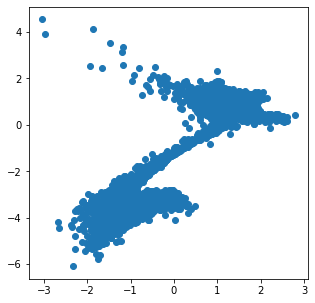

In [255]:
# Converting samples from base distribution to target distribution using Flows
test_samples_u = base_dist.sample(10000)
test_samples_x, _ = nf_rnvp.complete_forward(test_samples_u)
given.plot_samples_2d(test_samples_x)

In [256]:
# Generating target samples and calculatuing their probability using p*
target_samples = ptarget.sample(10000)
p_star_x = ptarget.prob(target_samples)

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 149 1191 4110 4409  141]


In [257]:
# Running the inverse model to find u and then compute the probability of x using NF model
u, log_det_jacob_inv_transf = nf_rnvp.complete_inverse(tf.cast(target_samples, dtype=tf.float32))
u = u.numpy()
log_det_jacob_inv_transf = log_det_jacob_inv_transf.numpy()

In [258]:
p_x = (p_u.prob(u).reshape(-1,1) * np.exp(log_det_jacob_inv_transf)).reshape(-1)

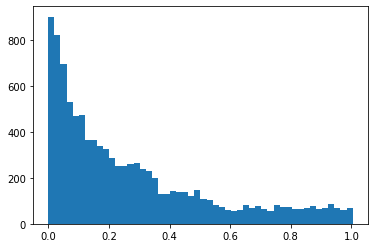

In [259]:
plt.hist(np.abs(p_star_x - p_x), density=False, bins=50)
plt.show()

## Planar Flow

In [260]:
class PlanarFlow(tf.Module):
    def __init__(self, D):
        super(PlanarFlow, self).__init__()
        self.c = tf.Variable(np.random.uniform(-1., 1., size=(int(D))), name='c', dtype=tf.float32, trainable=True)
        self.w = tf.Variable(np.random.uniform(-1., 1., size=(int(D))), name='w', dtype=tf.float32, trainable=True)
        self.b = tf.Variable(np.random.uniform(-1., 1., size=(1)), name='b', dtype=tf.float32, trainable=True)
    
    def h(self, x):
        return tf.math.tanh(x)
    
    def h_prime(self, x):
        return 1.0 - self.h(x)**2
    
    def _log_det_jacobian(self, u):
        val1 = tf.tensordot(u, self.w, 1) + self.b
        val2 = tf.tensordot(self.h_prime(val1), self.w, 0)
        det = tf.math.abs(1.0 + tf.tensordot(val2, self.c, 1))
        return tf.math.log(det)
    
    def _forward(self, u):
        val1 = self.h(tf.tensordot(u, self.w, 1) + self.b)
        log_det_jacob = self._log_det_jacobian(u)
        return u + tf.tensordot(val1, self.c, 0), log_det_jacob

In [261]:
class NormalizingFlowPlanar(tf.Module):
    def __init__(self, D=2, n_flows=4):
        super(NormalizingFlowPlanar, self).__init__()
        self.n_flows = n_flows
        self.planar_flow_chain = []
        for _ in range(self.n_flows):
            self.planar_flow_chain.append(PlanarFlow(D))
        
    def complete_forward(self, u):
        x = u
        log_det_jacob_forward_transf = 0
        for i in range(self.n_flows):
            x, log_s = self.planar_flow_chain[i]._forward(x)
            log_det_jacob_forward_transf = log_det_jacob_forward_transf + log_s
        return x, log_det_jacob_forward_transf

Given samples from $p_x^*(x)$, estimate the density using Planar flows.

In [262]:
nf_planar = NormalizingFlowPlanar()

We don't know the inverse of Planar Flow in closed form. So, instead of learning the transformation $T$, we learn the transformation $T^{-1}$ and apply the forward function of Planar Flow as it is


In [263]:
@tf.function
def train_density_estimation_from_sampling(data_batch, model, base_dist, optimizer): #batch):
    """
    data batch : samples from p*
    model : the planar flow model 
    base_dist : the gaussian base distribution
    optimizer : the optimier from tensorflow
    """
    with tf.GradientTape() as tape:
      u, log_det_jacob = model.complete_forward(data_batch)
      loss = -tf.reduce_mean(base_dist.log_prob(u) + log_det_jacob)
        
    gradients = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
    return loss

In [264]:
# Training the Planar Flow NF model
dataset_size = 100000
data = tf.cast(samples, dtype=tf.float32)
epochs = 20
optimizer = optimizers.Adam(learning_rate = 0.0001)
batch_size = 128
batches_per_epoch = dataset_size//batch_size+1
for i in range(epochs):
  for j in range(batches_per_epoch):
    data_batch = data[batch_size*j:batch_size*(j+1)]
    last_loss = train_density_estimation_from_sampling(data_batch, nf_planar, base_dist, optimizer)
  print(last_loss)

tf.Tensor(16.57469, shape=(), dtype=float32)
tf.Tensor(15.10486, shape=(), dtype=float32)
tf.Tensor(13.6305065, shape=(), dtype=float32)
tf.Tensor(12.203562, shape=(), dtype=float32)
tf.Tensor(10.866595, shape=(), dtype=float32)
tf.Tensor(9.665249, shape=(), dtype=float32)
tf.Tensor(8.63443, shape=(), dtype=float32)
tf.Tensor(7.7513843, shape=(), dtype=float32)
tf.Tensor(6.978417, shape=(), dtype=float32)
tf.Tensor(6.300851, shape=(), dtype=float32)
tf.Tensor(5.718343, shape=(), dtype=float32)
tf.Tensor(5.228004, shape=(), dtype=float32)
tf.Tensor(4.820284, shape=(), dtype=float32)
tf.Tensor(4.4835763, shape=(), dtype=float32)
tf.Tensor(4.206855, shape=(), dtype=float32)
tf.Tensor(3.9803104, shape=(), dtype=float32)
tf.Tensor(3.795411, shape=(), dtype=float32)
tf.Tensor(3.6447797, shape=(), dtype=float32)
tf.Tensor(3.522073, shape=(), dtype=float32)
tf.Tensor(3.4218454, shape=(), dtype=float32)


In [265]:
# test_samples_u = base_dist.sample(10000)
# test_samples_x, _ = nf_planar.complete_forward(test_samples_u)
# given.plot_samples_2d(test_samples_x)

NOTE : Since we are learning the transformation $T^{-1}$, it is not possible to generate samples from $p_x^*$ given samples from $p_u$.

In [266]:
# Generating samples from p* and calculating the probability 
target_samples = ptarget.sample(10000)
p_star_x = ptarget.prob(target_samples)

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 133 1222 4046 4446  153]


In [267]:
# Running the inverse model to find u and then compute the probability of x using NF model
u, log_det_jacob_inv_transf = nf_rnvp.complete_forward(tf.cast(target_samples, dtype=tf.float32))
u = u.numpy()
log_det_jacob_inv_transf = log_det_jacob_inv_transf.numpy()

In [268]:
p_x = (p_u.prob(u).reshape(-1,1) * np.exp(log_det_jacob_inv_transf)).reshape(-1)

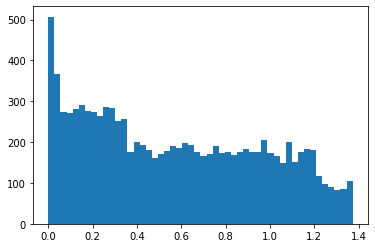

In [269]:
plt.hist(np.abs(p_star_x - p_x), density=False, bins=50)
plt.show()

In [270]:
##### Q1 b. #####

# Q1 b.

Given the function $p_x^*(x)$, generate samples from $p_u$ and use the function to estimate the target density. We use the Reverse KL Divergence loss in this case.

In [271]:
nf_rnvp_2 = NormalizingFlowRNVP(2, 4)

In [272]:
@tf.function
def train_density_estimation_reverse_kl(u_samples, model, p_star, optimizer):
    """
    u_samples : samples from base distribution
    model : the rnvp flow model 
    p_star : the target distribution function
    optimizer : the optimier from tensorflow
    """
    with tf.GradientTape() as tape:
        x, log_det_jacob_forward_transf = model.complete_forward(u_samples)
        x = tf.cast(x, tf.float64)
        log_det_jacob_forward_transf = tf.cast(log_det_jacob_forward_transf, tf.float64)
        print(x)
        print(log_det_jacob_forward_transf)
        loss = -tf.reduce_mean(log_det_jacob_forward_transf + p_star.log_prob(x))
    
    gradients = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
    return loss

In [273]:
# Training the RNVP NF model
dataset_size = 100000
epochs = 20
optimizer = optimizers.Adam(learning_rate = 0.0001)
batch_size = 128
batches_per_epoch = dataset_size//batch_size+1
for i in range(epochs):
  for j in range(batches_per_epoch):
    data_batch = base_dist.sample(batch_size, dtype=tf.float64)
    last_loss = train_density_estimation_reverse_kl(data_batch, nf_rnvp_2, mvgmm, optimizer)
  print(last_loss)

Tensor("Cast:0", shape=(128, 2), dtype=float64)
Tensor("Cast_1:0", shape=(128, 1), dtype=float64)
Tensor("Cast:0", shape=(128, 2), dtype=float64)
Tensor("Cast_1:0", shape=(128, 1), dtype=float64)
tf.Tensor(4.04966683305903, shape=(), dtype=float64)
tf.Tensor(3.7042193572690447, shape=(), dtype=float64)
tf.Tensor(3.5141954382799128, shape=(), dtype=float64)
tf.Tensor(3.7491943843180566, shape=(), dtype=float64)
tf.Tensor(3.5922184307440905, shape=(), dtype=float64)
tf.Tensor(3.661804998742886, shape=(), dtype=float64)
tf.Tensor(3.5455243900163382, shape=(), dtype=float64)
tf.Tensor(3.603178404744992, shape=(), dtype=float64)
tf.Tensor(3.6228186204565835, shape=(), dtype=float64)
tf.Tensor(3.7241983400700964, shape=(), dtype=float64)
tf.Tensor(3.62769443279055, shape=(), dtype=float64)
tf.Tensor(3.8047974025479716, shape=(), dtype=float64)
tf.Tensor(3.637031006898596, shape=(), dtype=float64)
tf.Tensor(3.676392280339071, shape=(), dtype=float64)
tf.Tensor(3.5764398797067063, shape=(), dt

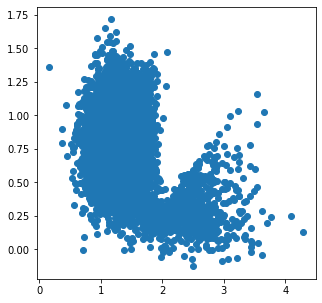

In [274]:
# Generate samples from base distribution and run the forward transformation to get x
test_samples_u = base_dist.sample(10000)
test_samples_x, log_det_jacob_forward_transf = nf_rnvp_2.complete_forward(test_samples_u)
given.plot_samples_2d(test_samples_x)

In [275]:
# Compute p_x from model
# pu = p_u.prob(test_samples_u.numpy())
# log_det_jacob_forward_transf = log_det_jacob_forward_transf.numpy()

In [276]:
# p_x = p_u.prob(test_samples_u.numpy()) * np.exp(-log_det_jacob_forward_transf).reshape(-1)

In [277]:
# p_star_x = ptarget.prob(test_samples_x.numpy())

In [278]:
# plt.hist(np.abs(p_star_x - p_x), density=True, bins=50)
# plt.show()

In [279]:
# Generate samples from ptarget ans then compare the p_x from the model
target_samples = ptarget.sample(10000)
p_star_x = ptarget.prob(target_samples)

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 149 1181 3972 4576  122]


In [280]:
u, log_det_jacob_inv_transf = nf_rnvp_2.complete_inverse(tf.cast(target_samples, dtype=tf.float32))
u = u.numpy()
log_det_jacob_inv_transf = log_det_jacob_inv_transf.numpy()

In [281]:
p_x = (p_u.prob(u).reshape(-1,1) * np.exp(log_det_jacob_inv_transf)).reshape(-1)

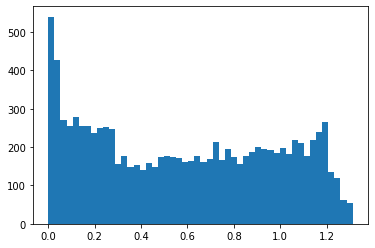

In [282]:
plt.hist(np.abs(p_star_x - p_x), density=False, bins=50)
plt.show()

Density Estimation using Planar Flows.

In [283]:
nf_planar_2 = NormalizingFlowPlanar()

In [284]:
@tf.function
def train_planar_flow_reverse_kl(u_samples, model, p_star, optimizer):
    """
    u_samples : samples from base distribution
    model : the planar flow model 
    p_star : the target distribution function
    optimizer : the optimier from tensorflow
    """
    with tf.GradientTape() as tape:
        x, log_det_jacob_forward_transf = model.complete_forward(u_samples)
        x = tf.cast(x, tf.float64)
        log_det_jacob_forward_transf = tf.cast(log_det_jacob_forward_transf, tf.float64)
        loss = -tf.reduce_mean(log_det_jacob_forward_transf + p_star.log_prob(x))
    
    gradients = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
    return loss

In [285]:
# Training the Planar Flow NF model
dataset_size = 100000
epochs = 20
optimizer = optimizers.Adam(learning_rate = 0.0001)
batch_size = 128
batches_per_epoch = dataset_size//batch_size+1
for i in range(epochs):
  for j in range(batches_per_epoch):
    data_batch = base_dist.sample(batch_size, dtype=tf.float64)
    last_loss = train_planar_flow_reverse_kl(data_batch, nf_planar_2, mvgmm, optimizer)
  print(last_loss)

tf.Tensor(27.625206454624745, shape=(), dtype=float64)
tf.Tensor(26.082496897233618, shape=(), dtype=float64)
tf.Tensor(24.691721479365903, shape=(), dtype=float64)
tf.Tensor(21.53741729643057, shape=(), dtype=float64)
tf.Tensor(20.875508642910013, shape=(), dtype=float64)
tf.Tensor(16.05664866385931, shape=(), dtype=float64)
tf.Tensor(14.58422585323775, shape=(), dtype=float64)
tf.Tensor(12.854908563158652, shape=(), dtype=float64)
tf.Tensor(13.198015133488298, shape=(), dtype=float64)
tf.Tensor(13.036557975249943, shape=(), dtype=float64)
tf.Tensor(8.797544468174488, shape=(), dtype=float64)
tf.Tensor(9.648411924454912, shape=(), dtype=float64)
tf.Tensor(8.62040271469095, shape=(), dtype=float64)
tf.Tensor(8.435150780291387, shape=(), dtype=float64)
tf.Tensor(7.63516671407941, shape=(), dtype=float64)
tf.Tensor(7.260125581103604, shape=(), dtype=float64)
tf.Tensor(6.127231898419901, shape=(), dtype=float64)
tf.Tensor(6.3862314419411135, shape=(), dtype=float64)
tf.Tensor(6.5351201467

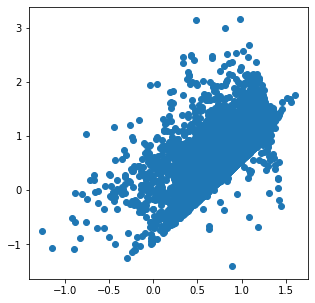

In [286]:
# Generating p* samples from the base distribution
test_samples_u = base_dist.sample(10000)
test_samples_x, log_det_jacob_forward_transf = nf_planar_2.complete_forward(test_samples_u)
given.plot_samples_2d(test_samples_x)

NOTE: In this Planar Flow model, we can't compute $T^{-1}$. So, for the historgrams, instead of generating samples from ```ptarget```, we are going to use $x = T(u)$ samples and compare with $p_x^*(x)$



In [287]:
pu = p_u.prob(test_samples_u.numpy())
log_det_jacob_forward_transf = log_det_jacob_forward_transf.numpy()

In [288]:
p_x = p_u.prob(test_samples_u.numpy()) * np.exp(-log_det_jacob_forward_transf).reshape(-1)

In [289]:
p_star_x = ptarget.prob(test_samples_x.numpy())

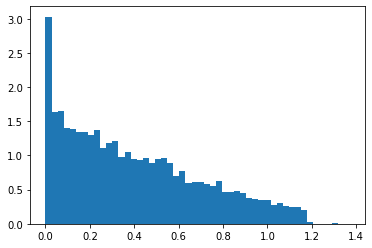

In [308]:
plt.hist(np.abs(p_star_x - p_x), density=True, bins=50)
plt.show()

## Q1 c.

In [291]:
##### Q1 c. #####
N = 10000 
x_samples = []
for i in range(5):
    num = int(ptarget.weights[i] * N)
    x_samples.append(ptarget.components[i].sample(num))

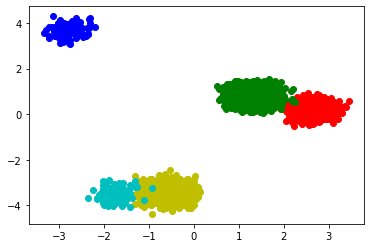

In [292]:
colors = ['b', 'r', 'y', 'g', 'c']
for i in range(5):
    plt.scatter(x_samples[i][:,0], x_samples[i][:,1], c=colors[i])
plt.show()

In [293]:
u_samples = []
for i in range(5):
    u, _= nf_rnvp.complete_inverse(tf.cast(x_samples[i], tf.float32))
    u_samples.append(u.numpy())

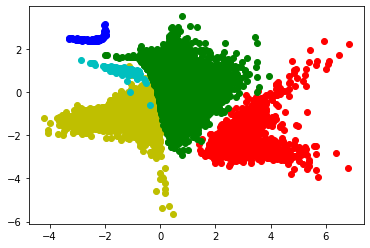

In [294]:
colors = ['b', 'r', 'y', 'g', 'c']
for i in range(5):
    plt.scatter(u_samples[i][:,0], u_samples[i][:,1], c=colors[i])
plt.show()

In [295]:
def most_probable_component(x, p_star):
    p_i = []
    for i in range(len(p_star.weights)):
        p_i.append(p_star.components[i].prob(x))
    return p_i.index(max(p_i))

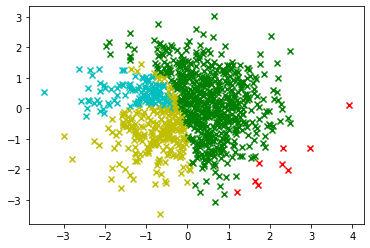

In [296]:
test_samples_u = base_dist.sample(1000)
test_samples_x, _ = nf_rnvp.complete_forward(test_samples_u)

# for i in range(5):
#     plt.scatter(x_samples[i][:,0], x_samples[i][:,1], c=colors[i])

test_samples_u = test_samples_u.numpy()
test_samples_x = test_samples_x.numpy().astype(np.float64)

for i in range(len(test_samples_u)):
    # print(test_samples_x[i].dtype)
    component = most_probable_component(test_samples_x[i].reshape(1,-1), ptarget)
    plt.scatter(test_samples_u[i][0], test_samples_u[i][1], c=colors[component], marker="x")

plt.show()

## YOUR OBSERVATIONS:

### Q1 a.
* The target distribution has components. But the Normalizing Flow (RNVP as well as Planar Flow) is not able to model those disjoint components. Even in the space which is supposed to be empty, we get samples from our model there since the NF model makes the distribution "flow" and so getting discontinuities seems unlikely.

* RNVP flow seems to give better target shapes compared to Planar Flows. The RNVP model makes use of Neural Networks which would have better modelling power. The Planar Flow form is relatively simple.  

* If we increase the Neural Network size of RNVP or increase the n_flows too much then training becomes slighly unstable. This could be an issue of the size of the dataset.

* RNVP gives a better histogram plot compared to Planar Flow since the number of samples with big mismatch between $p_x^*$ and $p_x$ are very less.

### Q1 b.
* We use the nf_rnvp with same parameters as 1a in this case too. But based on the samples generated, training rnvp flows using samples gives better results than training with the $p_x^*(x)$ function.  
* The Planar Flow model also doesn't generate samples which look like the target distribution.  
* Planar Flow gives a better histogram plot compared to RNVP since the number of samples with big mismatch between $p_x^*$ and $p_x$ are very less.

#### Common Points
A larger learning rate with the Adam optimizer became unstable and could lead to ```inf``` error.



### Q1 c. 

* For understanding the model better, we take the RNVP Flow.    
We first plot each component of the GMM in different colours. For each component cluster, we run the $T^{-1}$ on it and plot those $u$ in the same colour.   
This gives us some idea about where the corresponding components are coming from  

  

* Another experiment we run is taking samples from the base distribution and then transform them to get $x_i = T(u_i)$. Now for each $x_i$ we find which component of the GMM it is most likely to belong to and plot that $u_i$ in the same colour.  
This gives us some idea about division of space in the base distribution.


# Q2: Importance Sampling
Use the codes and models of Q1 to solve this problem
1. Assume you do not have access to `ptarget.sample()` but only to `ptarget.prob()`. Estimate $E[x^2]$ using the NF models of Q1a and Q1b. Write your obervations in the markdown block below the plots. [5 marks]
2. Evaluation: Now using the complete class `ptarget`, find $E[x^2]$ and compare it with the value computed in Q2.1. Write your obervations in the markdown block below the plots. [5 marks]

## YOUR CODE:

$\mathbb{E} [f] = \frac{1}{S} \sum_{i=1}^S f(x_i) \frac{p(x_i)}{q(x_i)}$ where $x_i$ ~ $q(x)$  
Here $q(x)$ is our Normalizing flow model

In [297]:
##### Q2.1 #####

# RNVP from 1a : 10 samples
u = base_dist.sample(10)
x, log_det_jacob_forward_transf = nf_rnvp.complete_forward(u)

u = u.numpy()
x = x.numpy()
log_det_jacob_inv_transf = -log_det_jacob_forward_transf.numpy()

q_x = (p_u.prob(u).reshape(-1,1) * np.exp(log_det_jacob_inv_transf)).reshape(-1)
p_x = ptarget.prob(x)
Ef = ((x**2) * (p_x/q_x).reshape(-1,1)).mean(axis=0)

print(Ef)

[0.84337156 1.26353491]


In [298]:
# RNVP from 1a : 100 samples
u = base_dist.sample(100)
x, log_det_jacob_forward_transf = nf_rnvp.complete_forward(u)

u = u.numpy()
x = x.numpy()
log_det_jacob_inv_transf = -log_det_jacob_forward_transf.numpy()

q_x = (p_u.prob(u).reshape(-1,1) * np.exp(log_det_jacob_inv_transf)).reshape(-1)
p_x = ptarget.prob(x)
Ef = ((x**2) * (p_x/q_x).reshape(-1,1)).mean(axis=0)

print(Ef)

[1.03022534 3.30677126]


In [299]:
# RNVP from 1a : 1000 samples
u = base_dist.sample(1000)
x, log_det_jacob_forward_transf = nf_rnvp.complete_forward(u)

u = u.numpy()
x = x.numpy()
log_det_jacob_inv_transf = -log_det_jacob_forward_transf.numpy()

q_x = (p_u.prob(u).reshape(-1,1) * np.exp(log_det_jacob_inv_transf)).reshape(-1)
p_x = ptarget.prob(x)
Ef = ((x**2) * (p_x/q_x).reshape(-1,1)).mean(axis=0)

print(Ef)

[4.88045725 5.58899565]


In [300]:
# RNVP from 1a : 10000 samples
u = base_dist.sample(10000)
x, log_det_jacob_forward_transf = nf_rnvp.complete_forward(u)

u = u.numpy()
x = x.numpy()
log_det_jacob_inv_transf = -log_det_jacob_forward_transf.numpy()

q_x = (p_u.prob(u).reshape(-1,1) * np.exp(log_det_jacob_inv_transf)).reshape(-1)
p_x = ptarget.prob(x)
Ef = ((x**2) * (p_x/q_x).reshape(-1,1)).mean(axis=0)

print(Ef)

[1.86192007 6.01427401]


In [301]:
# Planar Flow from 1b : 10 samples
u = base_dist.sample(10)
x, log_det_jacob_forward_transf = nf_planar_2.complete_forward(u)

u = u.numpy()
x = x.numpy()
log_det_jacob_inv_transf = -log_det_jacob_forward_transf.numpy()

q_x = p_u.prob(u) * np.exp(log_det_jacob_inv_transf).reshape(-1)
p_x = ptarget.prob(x)
# print(q_x.shape, p_x.shape)
Ef = ((x**2) * (p_x/q_x).reshape(-1,1)).mean(axis=0)

print(Ef)

[0.27112161 0.19213768]


In [302]:
# Planar Flow from 1b : 100 samples
u = base_dist.sample(100)
x, log_det_jacob_forward_transf = nf_planar_2.complete_forward(u)

u = u.numpy()
x = x.numpy()
log_det_jacob_inv_transf = -log_det_jacob_forward_transf.numpy()

q_x = p_u.prob(u) * np.exp(log_det_jacob_inv_transf).reshape(-1)
p_x = ptarget.prob(x)
# print(q_x.shape, p_x.shape)
Ef = ((x**2) * (p_x/q_x).reshape(-1,1)).mean(axis=0)

print(Ef)

[0.65030138 0.482233  ]


In [303]:
# Planar Flow from 1b : 1000 samples
u = base_dist.sample(1000)
x, log_det_jacob_forward_transf = nf_planar_2.complete_forward(u)

u = u.numpy()
x = x.numpy()
log_det_jacob_inv_transf = -log_det_jacob_forward_transf.numpy()

q_x = p_u.prob(u) * np.exp(log_det_jacob_inv_transf).reshape(-1)
p_x = ptarget.prob(x)
# print(q_x.shape, p_x.shape)
Ef = ((x**2) * (p_x/q_x).reshape(-1,1)).mean(axis=0)

print(Ef)

[0.7541463  0.40838107]


In [304]:
# Planar Flow from 1b : 10000 samples
u = base_dist.sample(10000)
x, log_det_jacob_forward_transf = nf_planar_2.complete_forward(u)

u = u.numpy()
x = x.numpy()
log_det_jacob_inv_transf = -log_det_jacob_forward_transf.numpy()

q_x = p_u.prob(u) * np.exp(log_det_jacob_inv_transf).reshape(-1)
p_x = ptarget.prob(x)
# print(q_x.shape, p_x.shape)
Ef = ((x**2) * (p_x/q_x).reshape(-1,1)).mean(axis=0)

print(Ef)

[0.98636129 0.51132148]


In [305]:
##### Q2.2 #####
S = [10, 100, 1000, 10000]
for s in S: 
    x_s = ptarget.sample(s)
    Ef = (x_s**2).mean(axis=0)
    print(s, " samples :", Ef)

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[0 2 3 5 0]
10  samples : [2.25819302 3.72906375]
[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1 10 41 46  2]
100  samples : [1.79897686 5.55703801]
[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 15 105 395 473  12]
1000  samples : [1.84378065 5.32502248]
[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 149 1218 4081 4416  136]
10000  samples : [1.92960755 5.48174355]


## YOUR OBSERVATIONS:

### Q2.1
RNVP Flow : Initially the estimates are bad, but when the we have around 10000 samples, Importance Sampling via RNVP gives us a decent estimate of $[1.86192007,\ 6.01427401]$
  

Planar Flow :  Planar Flow does not give us a nice estimate. 

We can try and explain this via the histograms.   
For rnvp in 1a, we get a good histogram, wherein most of our samples have very little difference in $p_x^*$ and $p_x$.  

However, for Planar Flow, there is a significant proportion of values where the difference between $p_x^*$ and $p_x$ is big and this is an issue we need to be careful of while doing importance sampling. We need $q(x)$ to be significant where $p(x)$ is significant.

### Q2.2
Monte Carlo Approximation from $p_x^*(x)$.  
As the number of samples increase, we start getting a stable value. 
At around ~1000 samples we start getting stable values :   
$\mathbb{E}[x^2] = [1.92960755,\ 5.48174355]$